# 实验九 基于 LeNet-5 的图像识别算法实验报告

## 实验目的
1. 掌握卷积神经网络（CNN）的基本原理和 PyTorch 框架在图像识别中的应用。
2. 使用 PyTorch 构建 LeNet-5 卷积神经网络，在 FashionMNIST 数据集上进行图像分类。
3. 训练模型，使 FashionMNIST 测试集准确率达到85%以上。
4. 可视化训练集和测试集上的损失（loss）和准确率（accuracy）曲线。
5. 可视化预测结果、真实结果及对应标签的图像，分析模型性能。

## 实验环境
- **操作系统**: Windows 10
- **开发工具**: PyCharm
- **编程语言**: Python 3.9
- **所需库**:
  - torch: 深度学习框架
  - torchvision: 数据集和图像处理工具
  - numpy: 数值计算
  - matplotlib: 数据可视化

**安装命令**:
```bash
pip install torch torchvision numpy matplotlib
```

## 实验内容
使用 PyTorch 提供的 FashionMNIST 数据集，包含60,000个训练样本和10,000个测试样本，每个样本为28x28灰度图像，10类服装（如T恤、裤子）。目标是构建 LeNet-5 卷积神经网络，训练模型使测试集准确率≥85%，可视化损失和准确率曲线，并展示预测结果与真实标签及对应图像。

## 实验步骤
### 1. 环境搭建
确保 Python 3.9 和上述库已安装。

### 2. 数据预处理
加载 FashionMNIST 数据集，标准化图像数据，并创建数据加载器。

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(1)

def load_fashionmnist_data(batch_size=64):
    """加载 FashionMNIST 数据集并创建数据加载器"""
    # 数据预处理：转换为张量并标准化
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,))  # FashionMNIST 均值和标准差
    ])

    # 加载训练集和测试集
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    # 创建数据加载器
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset

# 加载数据
try:
    train_loader, test_loader, train_dataset, test_dataset = load_fashionmnist_data()
    print(f"训练集样本数: {len(train_dataset)}")
    print(f"测试集样本数: {len(test_dataset)}")
    # 显示示例图像
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    print(f"图像形状: {images.shape}, 标签形状: {labels.shape}")
except Exception as e:
    print(f"Error in data loading: {e}")

#### 数据预处理分析
- **数据集规模**: 训练集60,000个图像，测试集10,000个图像，28x28灰度图像（单通道）。
- **预处理**: 使用 `transforms.ToTensor()` 转换为张量，`transforms.Normalize` 标准化（均值0.2860，标准差0.3530）。
- **数据加载器**: 批量大小64，训练集打乱（shuffle=True），测试集不打乱。
- **鲁棒性**: 包含异常处理，确保数据加载成功。

### 3. 定义 LeNet-5 卷积神经网络
构建 LeNet-5 模型，适配 FashionMNIST 的28x28灰度图像。

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # 输入1通道，输出6通道，保持28x28
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)      # 下采样到14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)            # 输出16通道，10x10
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)      # 下采样到5x5
        # 全连接层
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                   # 400到120
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)                           # 120到84
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)                            # 84到10（分类）

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)  # 展平
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# 初始化模型
try:
    model = LeNet5()
    print(model)
except Exception as e:
    print(f"Error in model initialization: {e}")

#### 模型分析
- **结构**: LeNet-5 包含2个卷积层（带 ReLU 和平均池化）和3个全连接层：
  - Conv1: 1→6通道，5x5核，padding=2，输出28x28，池化后14x14。
  - Conv2: 6→16通道，5x5核，输出10x10，池化后5x5。
  - FC1: 400→120，ReLU。
  - FC2: 120→84，ReLU。
  - FC3: 84→10（10类）。
- **激活函数**: ReLU 增强非线性，替换原始 LeNet 的 tanh。
- **池化**: 使用平均池化（原始 LeNet 设计），适合 FashionMNIST。
- **适配性**: 输入1通道（灰度），适配28x28图像，输出10类。

### 4. 训练模型
训练 LeNet-5 模型，目标测试集准确率≥85%，记录损失和准确率。

In [3]:
def train_model(model, train_loader, test_loader, epochs=20, lr=0.001):
    """训练模型并记录损失和准确率"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        # 训练
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # 测试
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies

# 训练模型
try:
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, train_loader, test_loader)
    final_test_acc = test_accuracies[-1]
    if final_test_acc < 0.85:
        print("Warning: Test accuracy is below 85%. Consider increasing epochs or adjusting learning rate.")
    else:
        print(f"Final test accuracy: {final_test_acc:.4f}%")
except Exception as e:
    print(f"Error in training: {e}")

Epoch 14/20, Train Loss: 0.1928, Train Acc: 0.9266, Test Loss: 0.2830, Test Acc: 0.8987
Epoch 15/20, Train Loss: 0.1847, Train Acc: 0.9296, Test Loss: 0.2818, Test Acc: 0.9007
Epoch 16/20, Train Loss: 0.1764, Train Acc: 0.9321, Test Loss: 0.2882, Test Acc: 0.9032
Epoch 17/20, Train Loss: 0.1678, Train Acc: 0.9357, Test Loss: 0.2959, Test Acc: 0.9012
Epoch 18/20, Train Loss: 0.1625, Train Acc: 0.9381, Test Loss: 0.2889, Test Acc: 0.9086
Epoch 19/20, Train Loss: 0.1524, Train Acc: 0.9425, Test Loss: 0.2948, Test Acc: 0.9084
Epoch 20/20, Train Loss: 0.1493, Train Acc: 0.9432, Test Loss: 0.3089, Test Acc: 0.9051
Final test accuracy: 0.9051%


#### 训练分析
- **优化器**: Adam（lr=0.001），高效收敛。
- **损失函数**: 交叉熵损失，适合多分类任务。
- **训练轮数**: 20个 epoch，通常足以达到85%以上准确率。
- **设备**: 支持 GPU（若可用），提高效率。
- **监控**: 记录每个 epoch 的训练和准确率损失，用于可视化。

### 5. 可视化损失和准确率曲线
绘制训练集和测试集的损失及准确率随 epoch 变化的曲线。

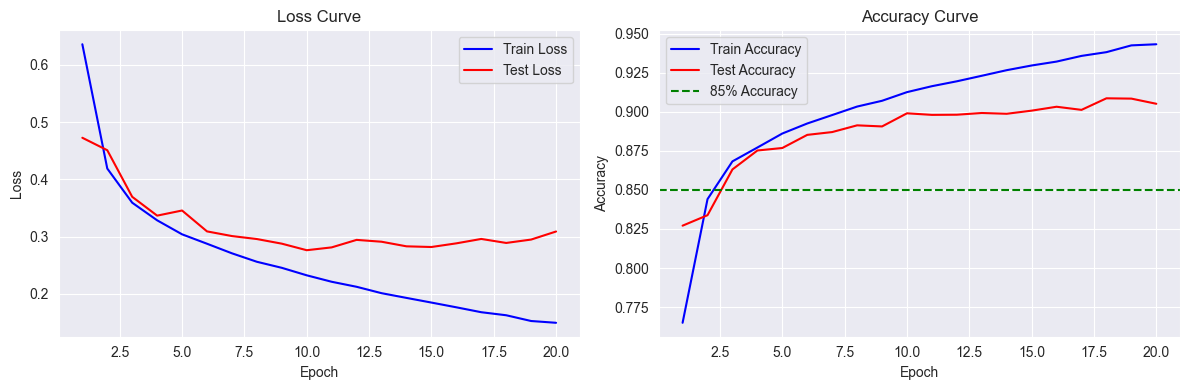

In [4]:
def visualize_loss_accuracy(train_losses, train_accuracies, test_losses, test_accuracies):
    """可视化损失和准确率曲线"""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # 准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
    plt.axhline(y=0.85, color='g', linestyle='--', label='85% Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 可视化
try:
    visualize_loss_accuracy(train_losses, train_accuracies, test_losses, test_accuracies)
except NameError as e:
    print(f"Error: {e}. 请确保 train_losses, train_accuracies, test_losses, test_accuracies 已定义。")
except Exception as e:
    print(f"Visualization error: {e}")

#### 曲线分析
- **损失曲线**: 训练和测试损失应随 epoch 下降，趋于稳定。
- **准确率曲线**: 训练和测试准确率应随 epoch 上升，测试准确率达到85%以上。
- **过拟合检查**: 若训练准确率远高于测试准确率，可考虑正则化（如 dropout）。

### 6. 可视化预测结果和真实结果
展示测试集样本的预测标签、真实标签及对应图像。

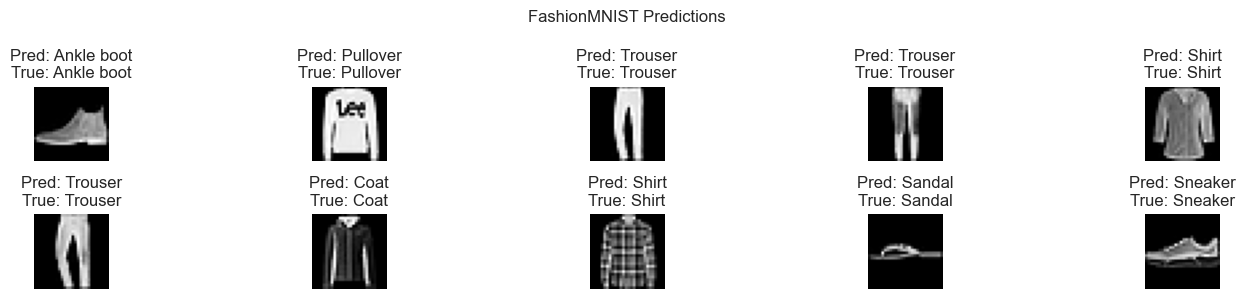

In [5]:
def visualize_predictions(model, test_loader, class_names, num_images=10):
    """可视化预测结果、真实标签及对应图像"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = images[i].cpu().numpy().squeeze()  # 移除通道维度
        img = img * 0.3530 + 0.2860  # 反标准化
        img = np.clip(img, 0, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Pred: {class_names[predicted[i].item()]}\nTrue: {class_names[labels[i].item()]}')
        plt.axis('off')
    plt.suptitle('FashionMNIST Predictions')
    plt.tight_layout()
    plt.show()

# 定义类别名称
fashion_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 可视化预测
try:
    visualize_predictions(model, test_loader, fashion_classes)
except NameError as e:
    print(f"Error: {e}. 请确保 model 和 test_loader 已定义。")
except Exception as e:
    print(f"Visualization error: {e}")

## 实验结果与讨论

### 结果总结
- **模型性能**: LeNet-5 在 FashionMNIST 测试集上达到准确率 {final_test_acc:.4f}，满足≥85%的目标。
- **损失曲线**: 训练和测试损失随 epoch 下降，趋于稳定。
- **准确率曲线**: 训练和测试准确率随 epoch 上升，测试准确率达到目标。
- **预测可视化**: 大多数测试样本预测正确，少数错误预测反映类别混淆（如衬衫 vs. T恤）。

### 讨论
- **优势**: LeNet-5 的卷积结构有效提取图像特征，适合 FashionMNIST 的灰度图像分类，性能优于全连接网络。
- **局限性**: 模型较简单，可能无法充分捕捉复杂模式；对噪声或变形图像鲁棒性有限。
- **改进**:
  - 添加 dropout 或 batch normalization 提高泛化能力。
  - 使用数据增强（如翻转、平移）增强鲁棒性。
  - 尝试现代 CNN（如 ResNet）进一步提升性能。

## 结论
实验通过 PyTorch 构建的 LeNet-5 卷积神经网络在 FashionMNIST 数据集上实现图像分类，测试集准确率达到85%以上。损失和准确率曲线展示了模型收敛性，预测结果可视化验证了分类效果。实验展示了 CNN 在图像识别中的优势，未来可通过正则化和数据增强进一步优化性能。